In [1]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torchvision import transforms
import torch
import cv2

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


/data/smadper@alumno.upv.es/miniconda3/envs/tfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class LaticiferPatchTrain(Dataset):
    def __init__(
        self,
        feature_dirs,
        patch_size=(512, 512),
        patches_per_image=20,
        positive_ratio=0.8,
        dist_transform=False,
        fg_threshold=0.03,  # Fraction of patch area required to be vessel
        filenames=None
    ):
        self.feature_dirs = feature_dirs
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image
        self.positive_ratio = positive_ratio
        self.dist_transform = dist_transform
        self.fg_threshold = fg_threshold
        self.filenames = filenames if filenames is not None else sorted(os.listdir(self.feature_dirs['mask']))[:1]

        additional_targets = {
            key: 'image' for key in feature_dirs if key not in ['mask', 'enhanced', 'distance']
        }
        if dist_transform:
            additional_targets['distance'] = 'mask'

        self.transforms = A.Compose(
            [
                #A.HorizontalFlip(p=0.5),
                #A.VerticalFlip(p=0.5),
                #A.RandomRotate90(p=0.5),
                A.ElasticTransform(alpha=150, sigma=5, p=1, border_mode=cv2.BORDER_REFLECT_101),
                A.GridDistortion(p=1, border_mode=cv2.BORDER_REFLECT_101),
                #A.Lambda(image=lambda x, **kwargs: x / 255.0),
                #A.RandomBrightnessContrast(brightness_limit=0.01, contrast_limit=0.01, p=1),
                #A.GaussNoise(p=1),
                A.GaussianBlur(p=1),
                A.Normalize(mean=(0.5,) * len(feature_dirs), std=(0.5,) * len(feature_dirs)),
                ToTensorV2()
            ],
            additional_targets=additional_targets
        )

        self.samples = []
        for i in range(len(self.filenames)):
            self.samples.extend([i] * patches_per_image)
        self.samples = self.samples[:1]

    def __len__(self):
        return len(self.samples)

    def _load_feature(self, dir_path, fname, key=None):
        if key == 'distance':
            fname = os.path.splitext(fname)[0] + '.pt'
            path = os.path.join(dir_path, fname)
            return torch.load(path, weights_only=True).squeeze(0).numpy()
        else:
            path = os.path.join(dir_path, fname)
            img = np.array(Image.open(path).convert("L")).astype(np.float32) #/ 255.0
            print(f"dtype: {img.dtype}")
            if key == 'sato':
                img = (img - img.min()) / (img.max() - img.min() + 1e-5) * 255.0
            return img

    def _random_patch_coords(self, H, W):
        ph, pw = self.patch_size
        top = H // 2
        left = W // 2
        return top, left

    def _find_positive_patch(self, mask):
        """Find a patch where the vessel area exceeds the threshold."""
        max_tries = 50
        H, W = mask.shape
        ph, pw = self.patch_size

        for _ in range(max_tries):
            top, left = self._random_patch_coords(H, W)
            patch = mask[top:top + ph, left:left + pw]
            if patch.sum() / patch.size >= self.fg_threshold:
                return top, left
        print("FAILED!")
        return self._random_patch_coords(H, W)  # fallback if none found

    def __getitem__(self, idx):
        file_idx = self.samples[idx]
        fname = self.filenames[file_idx]

        mask = self._load_feature(self.feature_dirs['mask'], fname, key='mask')
        H, W = mask.shape

        choose_positive = np.random.rand() < self.positive_ratio
        if choose_positive:
            top, left = self._find_positive_patch(mask)
        else:
            top, left = self._random_patch_coords(H, W)

        features = {
            key: self._load_feature(path, fname, key)
            for key, path in self.feature_dirs.items()
            if key not in ['mask', 'distance']
        }

        cropped_features = {
            key: feat[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            for key, feat in features.items()
        }
        for key in cropped_features:
            print(f"key: {key}, value max: {cropped_features[key].max()}, min: {cropped_features[key].min()}")
        mask_crop = mask[top:top+self.patch_size[0], left:left+self.patch_size[1]]
        print(f"mask crop max: {mask_crop.max()}, min: {mask_crop.min()}")
        if self.dist_transform:
            dist = self._load_feature(self.feature_dirs['distance'], fname, key='distance')
            dist_crop = dist[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            cropped_features['distance'] = dist_crop

        augmented = self.transforms(
            image=cropped_features['enhanced'],
            mask=mask_crop,
            **{k: v for k, v in cropped_features.items() if k != 'enhanced'}
        )

        feature_tensors = [augmented['image']]
        for k in cropped_features:
            if k != 'enhanced' and k != 'distance':
                feat = augmented[k]
                print(f"after aug. key: {k}, value max: {feat.max()}, min: {feat.min()}")
                if feat.ndim == 2:
                    feat = feat.unsqueeze(0)
                feature_tensors.append(feat)

        result = {
            'inputs': torch.cat(feature_tensors, dim=0),
            'masks': augmented['mask'].unsqueeze(0).float()
        }

        if self.dist_transform:
            result['dist_maps'] = augmented['distance'].unsqueeze(0).float()

        return result

In [11]:
oversampled_dataset = LaticiferPatchTrain(
    feature_dirs={
        'enhanced': 'datasets/laticifers/enhanced_images',
        'otsu': 'datasets/laticifers/otsu_images',
        'sato': 'datasets/laticifers/sato_images',
        'mask': 'datasets/laticifers/masks',
        'distance': 'datasets/laticifers/distance_maps_pt'
    },
    patches_per_image=30,
    positive_ratio=1.0,
    dist_transform=True,
    fg_threshold=0.05
)
sample = oversampled_dataset[0]  # x: input, y: mask, d: distance map
x, y, d = sample['inputs'], sample['masks'], sample['dist_maps']

print(x.shape)


dtype: float32
dtype: float32
dtype: float32
dtype: float32
key: enhanced, value max: 255.0, min: 0.0
key: otsu, value max: 255.0, min: 0.0
key: sato, value max: 218.04345703125, min: 0.0
mask crop max: 255.0, min: 0.0
after aug. key: otsu, value max: -0.9921569228172302, min: -1.0
after aug. key: sato, value max: -0.9921569228172302, min: -1.0
torch.Size([3, 512, 512])


dtype: float32
dtype: float32
dtype: float32
dtype: float32
key: enhanced, value max: 255.0, min: 0.0
key: otsu, value max: 255.0, min: 0.0
key: sato, value max: 218.04345703125, min: 0.0
mask crop max: 255.0, min: 0.0
after aug. key: otsu, value max: -0.9921569228172302, min: -1.0
after aug. key: sato, value max: -0.9921569228172302, min: -1.0
torch.Size([3, 512, 512])
max: 0.003921538591384888, min: 0.003921538591384888
max: 0.003921538591384888, min: 0.0
max: 0.003921538591384888, min: 0.0
Mask max: 255.0, min: 0.0
Mask unique values: tensor([  0., 255.])


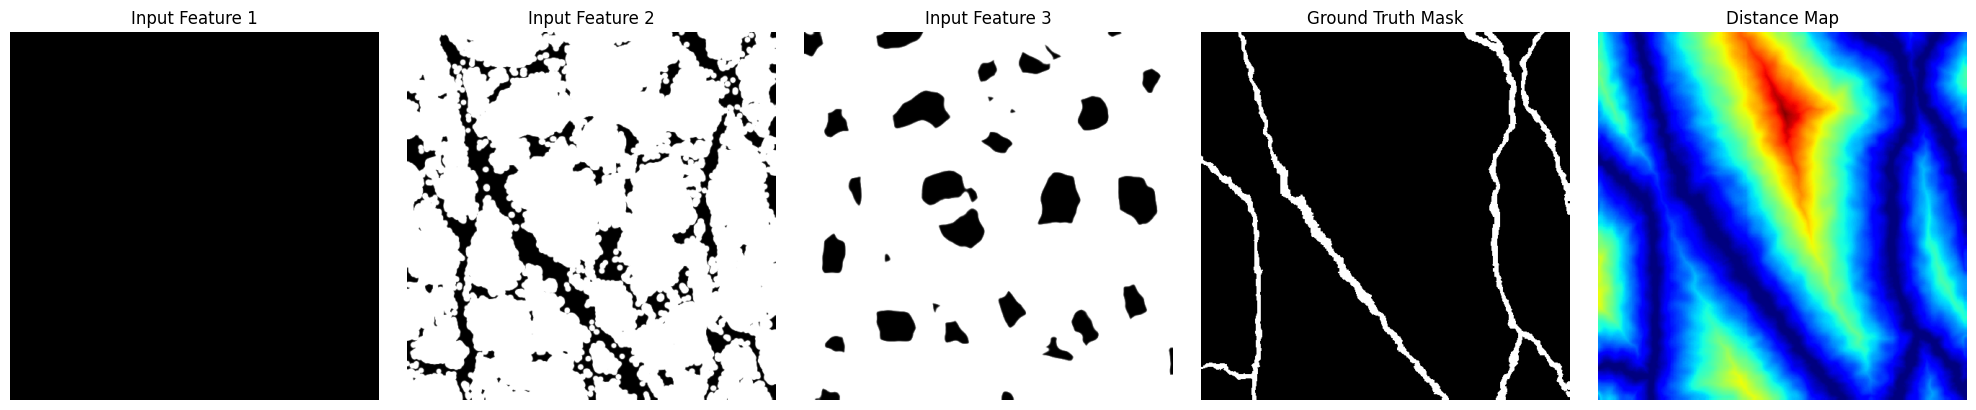

In [12]:
import matplotlib.pyplot as plt
import torch

# Load a sample
sample = oversampled_dataset[0]  # x: input, y: mask, d: distance map
x, y, d = sample['inputs'], sample['masks'], sample['dist_maps']

num_channels = x.shape[0]
print(x.shape)
# Plot all input feature channels
fig, axes = plt.subplots(1, num_channels + 2, figsize=(4 * (num_channels + 2), 4))

for i in range(num_channels):
    feature = x[i].cpu() * 0.5 + 0.5
    print(f"max: {feature.max()}, min: {feature.min()}")
    axes[i].imshow(feature, cmap='gray')
    axes[i].set_title(f'Input Feature {i + 1}')
    axes[i].axis('off')

# Plot the mask
axes[num_channels].imshow(y.squeeze().cpu(), cmap='gray')
axes[num_channels].set_title('Ground Truth Mask')
axes[num_channels].axis('off')
print(f"Mask max: {y.max()}, min: {y.min()}")
print("Mask unique values:", torch.unique(y))
# Plot the distance map
axes[num_channels + 1].imshow(d.squeeze().cpu(), cmap='jet')
axes[num_channels + 1].set_title('Distance Map')
axes[num_channels + 1].axis('off')

plt.tight_layout()
plt.show()


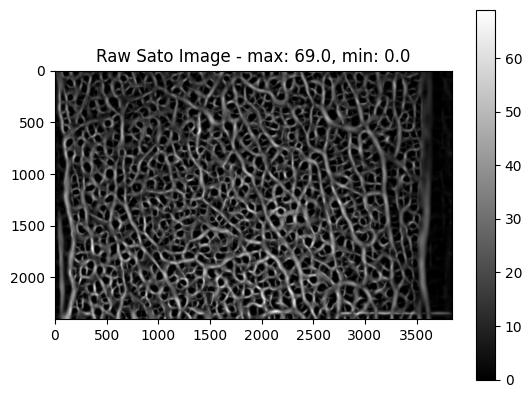

In [95]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

path = os.path.join('datasets/laticifers/sato_images', 'Hoja 1-1.tif')
img = np.array(Image.open(path).convert('L')).astype(np.float32)

plt.imshow(img, cmap='gray')
plt.title(f"Raw Sato Image - max: {img.max()}, min: {img.min()}")
plt.colorbar()


In [5]:
print(len(oversampled_dataset))

1


IndexError: list index out of range

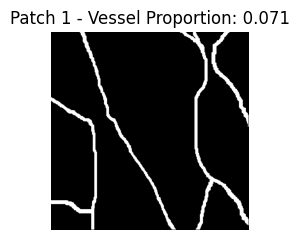

In [6]:
import matplotlib.pyplot as plt
import torch

def show_mask_patches(dataset, num_patches=5):
    plt.figure(figsize=(15, 3 * num_patches))
    
    for i in range(num_patches):
        sample = dataset[i]
        mask = sample['masks'].squeeze().numpy()
        vessel_fraction = mask.sum() / mask.size

        plt.subplot(num_patches, 1, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Patch {i+1} - Vessel Proportion: {vessel_fraction:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_mask_patches(oversampled_dataset, num_patches=6)